# Phytoplankton Primary Composition end-to-end: HPO → train → evaluate → SHAP (dataset-agnostic)

This notebook runs the full pipeline using the installed `phyx` package.

**Prereqs**
- Environment created/activated
- Package installed: `pip install -e . --no-deps`
- Dataset folder with Parquet files:
    * df_rrs.pqt # feature columns (e.g., Rrs_* and/or ancillary features)
    * df_phyto.pqt # targets: dia, chl, cya, coc, din, pha, tot_chla
    * df_env.pqt # optional (aligned rows)


**Flow**
1. Load features/targets (and optional env)
2. Train/test split
3. Optuna HPO (KFold inside objective)
4. Train on full training split with best params
5. Evaluate on test split; save metrics
6. SHAP values + per-target summary plots
7. (Optional) Train final production model on all data


---
## 1) Setup: imports, logging, paths, and versions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json

from loguru import logger

# Configure concise logging for notebooks
logger.remove()
logger.add(lambda msg: print(msg, end=""), level="INFO")

# --- Set your paths & options here ---
#DATA_DIR = Path("your_data_path")       # <-- change to your dataset folder
DATA_DIR = Path.home() / 'data/craig_pfc_2023/step_2_cleaned'
assert DATA_DIR.exists(), f"Data directory {DATA_DIR} does not exist!"
OUTDIR   = Path("artifacts/pace_run")     # where outputs are written
TEST_SIZE = 0.20
SEED = 42
# -----------------------
# HPO SMOKE TEST
#N_TRIALS = 1 
#K_FOLDS = 2 # (min: 2)
# -----------------------
# HPO REGULAR RUN
N_TRIALS = 50
K_FOLDS = 3
# -----------------------

OUTDIR.mkdir(parents=True, exist_ok=True)

# Versions (optional but helpful)
import numpy, pandas, xgboost, sklearn, shap, optuna
logger.info(
    "Versions → numpy={}, pandas={}, xgboost={},\n sklearn={}, shap={}, optuna={}\n",
    numpy.__version__, pandas.__version__, xgboost.__version__,
    sklearn.__version__, shap.__version__, optuna.__version__
)

/Users/erdemkarakoylu/miniconda3/envs/phyx/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-09-04 16:11:40.847 | INFO     | __main__:<module>:31 - Versions → numpy=2.2.6, pandas=2.2.3, xgboost=2.1.4,
 sklearn=1.6.1, shap=0.46.0, optuna=4.5.0



## 2) Load data

Loads `df_rrs.pqt` (features) and `df_phyto.pqt` (targets). If `df_env.pqt` exists, it’s concatenated to features. Basic sanity checks ensure numeric columns and aligned rows.

In [3]:
from phyx.pipeline.data_loader import DataLoader
import pandas as pd

dl = DataLoader(
    DATA_DIR, rrs_file='df_rrs_pace_sub.pqt', env_file='df_env.pqt',
    phy_file='df_phy.pqt')
X_df, Xenv_df, Y_df = dl.load_data()
if Xenv_df is not None:
    X_df = X_df.join(Xenv_df)

# Sanity checks
non_numeric = [c for c in X_df.columns if not pd.api.types.is_numeric_dtype(X_df[c])]
if non_numeric:
    raise TypeError(f"Non-numeric feature columns detected (first few): {non_numeric[:5]}")
assert X_df.shape[0] == Y_df.shape[0], "Row count mismatch between X and Y."

logger.info("Loaded X: {} rows × {} cols | Y: {} rows × {} targets\n",
            X_df.shape[0], X_df.shape[1], Y_df.shape[0], Y_df.shape[1])

2025-09-04 16:11:48.713 | INFO     | phyx.pipeline.data_loader:load_data:29 - Loaded X=%s, Y=%s%s
2025-09-04 16:11:48.766 | INFO     | __main__:<module>:17 - Loaded X: 1261607 rows × 41 cols | Y: 1261607 rows × 7 targets



In [4]:
targets = Y_df.columns.tolist()

## 3) Train/test split + schema guard

Create a deterministic split and verify that feature **names and order** match between train and test.

In [5]:
from sklearn.model_selection import train_test_split

Xtr, Xte, Ytr, Yte = train_test_split(X_df, Y_df, test_size=TEST_SIZE, random_state=SEED)
logger.info("Split → train: {} rows, test: {} rows\n", Xtr.shape[0], Xte.shape[0])

# Fail fast if schema differs
if list(Xtr.columns) != list(Xte.columns):
    missing = [c for c in Xtr.columns if c not in Xte.columns]
    extra   = [c for c in Xte.columns if c not in Xtr.columns]
    moved   = [c for c in Xtr.columns if c in Xte.columns and Xtr.columns.get_loc(c) != Xte.columns.get_loc(c)]
    raise ValueError(f"Feature schema mismatch.\nMissing in test: {missing}\nExtra in test: {extra}\nReordered: {moved}")

2025-09-04 16:11:59.427 | INFO     | __main__:<module>:4 - Split → train: 1009285 rows, test: 252322 rows



It's best to save the training and testing splits to disk for future reference. The code cell below does that.

In [29]:
Xtr.to_parquet(OUTDIR / "X_train.pqt")
Ytr.to_parquet(OUTDIR / "Y_train.pqt")
Xte.to_parquet(OUTDIR / "X_test.pqt")
Yte.to_parquet(OUTDIR / "Y_test.pqt")

## 4) Hyperparameter optimization (Optuna)

Runs KFold CV inside the objective for each trial. Saves `best_params.json`.


In [6]:
import optuna
from phyx.pipeline.optuna_hpo import objective

study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, Xtr, Ytr, kfolds=K_FOLDS), 
    n_trials=N_TRIALS, show_progress_bar=False)

best_params = {**study.best_trial.params, "objective": "reg:squarederror"}
best_path = OUTDIR / "best_params.json"
best_path.write_text(json.dumps(best_params, indent=2))

logger.info("Best RMSE={:.4f}\n", study.best_value)
logger.info("Saved best params → {}\n", best_path)
best_params


[I 2025-09-04 16:12:08,493] A new study created in memory with name: no-name-83bed200-3ad7-40a6-ab0f-47a84f9a4e69


2025-09-04 16:12:08.700 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:13:41.198 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:13:46.810 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:15:19.087 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:15:25.027 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:16:56.940 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:17:02,320] Trial 0 finished with value: 0.016478088447622174 and parameters: {'learning_rate': 0.08120170297948594, 'max_depth': 9, 'n_estimators': 491, 'subsample': 0.9469914410228826, 'colsample_bytree': 0.9088101839451497, 'gamma': 1.6773657084281613e-06}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:17:02.493 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:17:42.161 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:17:44.141 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:18:22.227 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:18:24.121 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:19:03.541 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:19:05,323] Trial 1 finished with value: 0.023312836429796913 and parameters: {'learning_rate': 0.29232684631569855, 'max_depth': 4, 'n_estimators': 465, 'subsample': 0.8102330530044339, 'colsample_bytree': 0.7152839726737938, 'gamma': 1.431265618311857e-07}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:19:05.497 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:19:24.642 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:19:25.598 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:19:44.911 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:19:45.872 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:20:05.101 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:20:05,914] Trial 2 finished with value: 0.14171934139191159 and parameters: {'learning_rate': 0.004895783046493895, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.6090623024049344, 'colsample_bytree': 0.6130525943699441, 'gamma': 4.1198789484582085e-07}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:20:06.091 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:20:48.884 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:20:50.773 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:21:38.077 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:21:40.361 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:22:32.722 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:22:34,905] Trial 3 finished with value: 0.11547807529122738 and parameters: {'learning_rate': 0.002440448240960499, 'max_depth': 5, 'n_estimators': 349, 'subsample': 0.7927459160975141, 'colsample_bytree': 0.8458299061674144, 'gamma': 0.0007054573181227193}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:22:35.167 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:23:06.175 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:23:07.547 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:23:39.149 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:23:40.437 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:24:09.278 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:24:10,188] Trial 4 finished with value: 0.060408286819680836 and parameters: {'learning_rate': 0.018115175862633694, 'max_depth': 3, 'n_estimators': 289, 'subsample': 0.8332156505817964, 'colsample_bytree': 0.9521446544442141, 'gamma': 1.3880534399279144e-07}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:24:10.383 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:24:39.701 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:24:41.481 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:25:10.688 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:25:12.576 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:25:42.299 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:25:44,112] Trial 5 finished with value: 0.02153975035395089 and parameters: {'learning_rate': 0.07697587877492464, 'max_depth': 9, 'n_estimators': 153, 'subsample': 0.9440550533277208, 'colsample_bytree': 0.5699037597188594, 'gamma': 0.005657332748261933}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:25:44.314 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:26:00.151 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:26:00.902 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:26:16.391 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:26:17.073 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:26:32.431 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:26:32,930] Trial 6 finished with value: 0.035174322017190895 and parameters: {'learning_rate': 0.2505437421678685, 'max_depth': 8, 'n_estimators': 199, 'subsample': 0.6310696580373267, 'colsample_bytree': 0.6600555162641621, 'gamma': 0.3655701933138541}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:26:33.139 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:27:47.034 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:27:51.341 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:29:05.902 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:29:10.213 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:30:25.231 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:30:29,371] Trial 7 finished with value: 0.021627899377614477 and parameters: {'learning_rate': 0.03271859388829228, 'max_depth': 8, 'n_estimators': 495, 'subsample': 0.6324490035509556, 'colsample_bytree': 0.5860398743618138, 'gamma': 0.0022849304418637245}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:30:29.573 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:31:29.188 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:31:31.914 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:32:31.849 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:32:34.609 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:33:35.873 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:33:38,455] Trial 8 finished with value: 0.1356115018894946 and parameters: {'learning_rate': 0.0016390241401938476, 'max_depth': 6, 'n_estimators': 374, 'subsample': 0.6450110465984531, 'colsample_bytree': 0.7327820038234488, 'gamma': 0.009506916744501496}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:33:38.667 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:34:00.301 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:34:01.481 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:34:22.732 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:34:23.902 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:34:45.198 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:34:46,184] Trial 9 finished with value: 0.20343789130455928 and parameters: {'learning_rate': 0.0013680893207139722, 'max_depth': 7, 'n_estimators': 96, 'subsample': 0.5499456548527066, 'colsample_bytree': 0.6236878073163481, 'gamma': 0.003076635168214233}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:34:46.395 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:36:32.302 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:36:38.530 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:57:16.741 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 16:57:22.177 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 16:59:05.989 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 16:59:11,974] Trial 10 finished with value: 0.016529474371668542 and parameters: {'learning_rate': 0.06878622534110138, 'max_depth': 10, 'n_estimators': 420, 'subsample': 0.9994575183762187, 'colsample_bytree': 0.9813354995299518, 'gamma': 1.1203839540760692e-05}. Best is trial 0 with value: 0.016478088447622174.


2025-09-04 16:59:12.168 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:01:02.773 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:01:09.062 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:03:00.969 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:03:07.321 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:05:00.498 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:05:06,727] Trial 11 finished with value: 0.016450453760739666 and parameters: {'learning_rate': 0.07181125455663598, 'max_depth': 10, 'n_estimators': 424, 'subsample': 0.9952130536600561, 'colsample_bytree': 0.9794886620045717, 'gamma': 7.683391064316542e-06}. Best is trial 11 with value: 0.016450453760739666.


2025-09-04 17:05:06.925 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:06:55.618 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:07:01.858 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:08:50.690 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:08:56.965 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:10:45.950 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:10:52,075] Trial 12 finished with value: 0.016423207835267847 and parameters: {'learning_rate': 0.06793528352245257, 'max_depth': 10, 'n_estimators': 403, 'subsample': 0.9003640683401894, 'colsample_bytree': 0.8736878879736791, 'gamma': 7.056332410321885e-06}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:10:52.271 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:12:40.388 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:12:45.538 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:14:33.642 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:14:38.823 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:16:27.165 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:16:32,207] Trial 13 finished with value: 0.037368781280071185 and parameters: {'learning_rate': 0.007928872973858525, 'max_depth': 10, 'n_estimators': 303, 'subsample': 0.8822275668787225, 'colsample_bytree': 0.8576532586159297, 'gamma': 3.1051247578262224e-05}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:16:32.411 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:18:34.231 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:18:40.786 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:20:41.614 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:20:48.286 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:22:49.381 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:22:55,867] Trial 14 finished with value: 0.018169777230615396 and parameters: {'learning_rate': 0.0343177668070951, 'max_depth': 10, 'n_estimators': 404, 'subsample': 0.7185755069771331, 'colsample_bytree': 0.8148907959043646, 'gamma': 1.300791333344454e-08}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:22:56.070 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:23:57.863 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:24:01.255 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:25:03.794 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:25:07.226 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:26:09.708 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:26:12,893] Trial 15 finished with value: 0.017498137470826913 and parameters: {'learning_rate': 0.13866325303198446, 'max_depth': 8, 'n_estimators': 336, 'subsample': 0.8988719618301919, 'colsample_bytree': 0.9972814258963723, 'gamma': 0.00016374297347310638}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:26:13.102 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:27:15.250 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:27:18.457 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:28:20.113 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:28:23.331 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:29:25.531 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:29:28,662] Trial 16 finished with value: 0.022833698950330494 and parameters: {'learning_rate': 0.038512448574621334, 'max_depth': 9, 'n_estimators': 223, 'subsample': 0.9989641725624354, 'colsample_bytree': 0.9154498550573823, 'gamma': 7.54128122923982e-06}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:29:28.875 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:30:52.461 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:30:56.542 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:32:21.806 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:32:26.108 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:33:51.023 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:33:54,997] Trial 17 finished with value: 0.03661161732616613 and parameters: {'learning_rate': 0.011356836974597327, 'max_depth': 7, 'n_estimators': 421, 'subsample': 0.725079097263262, 'colsample_bytree': 0.8073369387612793, 'gamma': 0.00010904885271242873}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:33:55.206 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:35:05.358 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:35:09.445 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:36:15.941 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:36:20.063 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:37:26.646 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:37:30,570] Trial 18 finished with value: 0.01735938380100754 and parameters: {'learning_rate': 0.1419931243102398, 'max_depth': 10, 'n_estimators': 242, 'subsample': 0.8806675762041529, 'colsample_bytree': 0.5069802001306588, 'gamma': 3.510813691207518e-06}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:37:30.779 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:39:31.596 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:39:37.800 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:41:39.445 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:41:45.673 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:43:47.040 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:43:53,070] Trial 19 finished with value: 0.021605661508515752 and parameters: {'learning_rate': 0.022487972949352116, 'max_depth': 9, 'n_estimators': 447, 'subsample': 0.9521890736199283, 'colsample_bytree': 0.9051490550825729, 'gamma': 1.4105469676482318e-08}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:43:53.272 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:44:29.578 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:44:31.117 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:45:07.024 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:45:08.577 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:45:44.446 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:45:45,767] Trial 20 finished with value: 0.024182572335582467 and parameters: {'learning_rate': 0.14354973800468576, 'max_depth': 8, 'n_estimators': 378, 'subsample': 0.8499852094065421, 'colsample_bytree': 0.7818555926044549, 'gamma': 0.044944960680438}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:45:45.987 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:47:44.735 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:47:51.532 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:49:49.524 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:49:56.233 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:51:54.835 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 17:52:01,334] Trial 21 finished with value: 0.01659759440993221 and parameters: {'learning_rate': 0.07144616301737226, 'max_depth': 9, 'n_estimators': 492, 'subsample': 0.9418991044070963, 'colsample_bytree': 0.9062209441725513, 'gamma': 7.765217671460624e-07}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 17:52:01.534 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:54:18.918 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:54:26.286 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 17:56:43.313 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 17:56:50.697 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:21:54.682 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 18:22:00,529] Trial 22 finished with value: 0.01668588233427365 and parameters: {'learning_rate': 0.05264578970948877, 'max_depth': 10, 'n_estimators': 453, 'subsample': 0.9215394049886553, 'colsample_bytree': 0.943502177805643, 'gamma': 2.0783486431909534e-06}. Best is trial 12 with value: 0.016423207835267847.


2025-09-04 18:22:00.708 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:33:46.980 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 18:33:52.219 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:35:19.371 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 18:35:24.592 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:36:54.796 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 18:37:00,044] Trial 23 finished with value: 0.016234543399905696 and parameters: {'learning_rate': 0.12002906634596094, 'max_depth': 9, 'n_estimators': 497, 'subsample': 0.9745712981310184, 'colsample_bytree': 0.8852081645688333, 'gamma': 3.418007856784518e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 18:37:00.238 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:38:24.914 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 18:38:29.842 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:39:54.360 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 18:39:59.396 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:41:24.609 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 18:41:29,485] Trial 24 finished with value: 0.016328224321430322 and parameters: {'learning_rate': 0.1284626733214564, 'max_depth': 10, 'n_estimators': 394, 'subsample': 0.99763788331842, 'colsample_bytree': 0.8737953930530191, 'gamma': 3.0557708921857055e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 18:41:29.679 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:57:28.460 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 18:57:31.578 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:58:24.846 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 18:58:28.199 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 18:59:25.287 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 18:59:28,622] Trial 25 finished with value: 0.01707562388894857 and parameters: {'learning_rate': 0.18551783889597104, 'max_depth': 9, 'n_estimators': 323, 'subsample': 0.9681308822237618, 'colsample_bytree': 0.855982115683298, 'gamma': 5.413278817708439e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 18:59:28.813 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:00:18.562 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:00:21.365 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:01:11.830 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:01:14.641 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:02:06.047 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:02:08,782] Trial 26 finished with value: 0.019231428857110534 and parameters: {'learning_rate': 0.1122970118222518, 'max_depth': 7, 'n_estimators': 370, 'subsample': 0.770149903100475, 'colsample_bytree': 0.7779903278344931, 'gamma': 0.0007287893332977325}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:02:08.986 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:03:11.454 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:03:14.933 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:04:17.933 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:04:21.418 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:05:24.646 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:05:27,997] Trial 27 finished with value: 0.01717529129489191 and parameters: {'learning_rate': 0.21130302285816077, 'max_depth': 10, 'n_estimators': 398, 'subsample': 0.8997757343049063, 'colsample_bytree': 0.8731271669099377, 'gamma': 0.0003801286574451867}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:05:28.193 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:05:45.581 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:05:46.594 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:06:03.867 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:06:04.869 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:06:22.094 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:06:22,876] Trial 28 finished with value: 0.04075585145748607 and parameters: {'learning_rate': 0.046459985251322035, 'max_depth': 8, 'n_estimators': 58, 'subsample': 0.9151578803776794, 'colsample_bytree': 0.8280131107982752, 'gamma': 2.4393395572711663e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:06:23.085 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:07:47.770 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:07:53.142 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:09:20.227 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:09:25.562 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:10:52.562 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:10:57,415] Trial 29 finished with value: 0.016311136895246575 and parameters: {'learning_rate': 0.102537608045003, 'max_depth': 9, 'n_estimators': 473, 'subsample': 0.861149155814432, 'colsample_bytree': 0.6945125185892668, 'gamma': 0.00020102563716047162}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:10:57.619 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:11:41.916 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:11:43.876 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:12:27.701 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:12:29.662 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:13:13.608 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:13:15,349] Trial 30 finished with value: 0.022292279337161325 and parameters: {'learning_rate': 0.09753469111824607, 'max_depth': 9, 'n_estimators': 461, 'subsample': 0.8618421715052587, 'colsample_bytree': 0.7063529008362908, 'gamma': 0.02948852767450854}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:13:15.561 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:14:41.624 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:14:46.762 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:16:13.795 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:16:18.848 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:17:46.085 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:17:51,005] Trial 31 finished with value: 0.016341721110332028 and parameters: {'learning_rate': 0.11108049429067053, 'max_depth': 9, 'n_estimators': 471, 'subsample': 0.967820693805626, 'colsample_bytree': 0.690633988780998, 'gamma': 0.00015186265325786306}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:17:51.210 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:19:17.191 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:19:22.389 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:20:51.787 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:20:57.036 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:22:26.913 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:22:31,955] Trial 32 finished with value: 0.016581007099354953 and parameters: {'learning_rate': 0.1846025388026463, 'max_depth': 9, 'n_estimators': 499, 'subsample': 0.9717710548157121, 'colsample_bytree': 0.6826676722277963, 'gamma': 0.00014580709501667828}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:22:32.167 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:23:46.127 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:23:50.327 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:25:04.593 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:25:08.769 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:26:23.417 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:26:27,459] Trial 33 finished with value: 0.0176072363481855 and parameters: {'learning_rate': 0.2796025694603166, 'max_depth': 8, 'n_estimators': 468, 'subsample': 0.8175372413550204, 'colsample_bytree': 0.7616166681840647, 'gamma': 0.0002702993979085266}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:26:27.668 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:27:23.302 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:27:25.889 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:28:22.044 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:28:24.644 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:29:20.854 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:29:23,268] Trial 34 finished with value: 0.02424397026105808 and parameters: {'learning_rate': 0.11525379306475178, 'max_depth': 5, 'n_estimators': 441, 'subsample': 0.9663837739094617, 'colsample_bytree': 0.6492912894551522, 'gamma': 0.0008260490300429959}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:29:23.490 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:31:26.325 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:31:32.971 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:33:34.380 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:33:41.015 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:35:42.780 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:35:49,199] Trial 35 finished with value: 0.02084667560631499 and parameters: {'learning_rate': 0.024578349536315207, 'max_depth': 9, 'n_estimators': 473, 'subsample': 0.9246006668037254, 'colsample_bytree': 0.7024171269850144, 'gamma': 4.501464351455951e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:35:49.404 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:36:39.651 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:36:41.756 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:37:31.540 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:37:33.533 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:38:23.727 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:38:25,427] Trial 36 finished with value: 0.03772732062681228 and parameters: {'learning_rate': 0.10018439133792788, 'max_depth': 3, 'n_estimators': 473, 'subsample': 0.796525757543921, 'colsample_bytree': 0.7345721556276656, 'gamma': 2.359371630177074e-07}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:38:25.659 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:39:47.705 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:39:52.653 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:41:15.498 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:41:20.601 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:42:43.509 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:42:48,327] Trial 37 finished with value: 0.017892807040111845 and parameters: {'learning_rate': 0.299349864836026, 'max_depth': 9, 'n_estimators': 434, 'subsample': 0.9417829356304944, 'colsample_bytree': 0.656547495871959, 'gamma': 1.909105692989053e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:42:48.530 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:43:57.151 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:44:00.340 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:45:09.362 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:45:12.611 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:46:21.919 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:46:24,953] Trial 38 finished with value: 0.030357779180024785 and parameters: {'learning_rate': 0.04829224188965583, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8392030439357703, 'colsample_bytree': 0.6781161555182401, 'gamma': 7.292956833929498e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:46:25.171 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:47:19.371 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:47:22.333 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:48:16.144 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:48:19.032 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:49:13.305 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:49:15,987] Trial 39 finished with value: 0.018657461911763124 and parameters: {'learning_rate': 0.17600140071462209, 'max_depth': 7, 'n_estimators': 357, 'subsample': 0.9650699818781782, 'colsample_bytree': 0.6004501151243444, 'gamma': 0.0013212668358501204}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:49:16.200 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:50:19.358 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:50:22.001 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:51:24.208 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:51:26.801 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:52:29.597 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 19:52:31,962] Trial 40 finished with value: 0.05401574816359183 and parameters: {'learning_rate': 0.01028347500341124, 'max_depth': 4, 'n_estimators': 475, 'subsample': 0.8721283291272565, 'colsample_bytree': 0.7439961413756331, 'gamma': 0.0003440326354552381}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 19:52:32.180 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:54:26.542 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:54:32.699 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 19:56:26.381 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 19:56:32.568 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:14:13.965 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:14:19,345] Trial 41 finished with value: 0.016381284423496095 and parameters: {'learning_rate': 0.0858211075768452, 'max_depth': 10, 'n_estimators': 385, 'subsample': 0.9822862602518363, 'colsample_bytree': 0.8821352599876575, 'gamma': 6.361863805244001e-06}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:14:19.540 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:34:16.251 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:34:20.031 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:35:48.414 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:35:52.651 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:37:23.311 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:37:27,443] Trial 42 finished with value: 0.09882748063798034 and parameters: {'learning_rate': 0.003529166907470773, 'max_depth': 10, 'n_estimators': 263, 'subsample': 0.9842729282915531, 'colsample_bytree': 0.9453781454103384, 'gamma': 6.452866440388285e-08}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:37:27.638 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:38:53.626 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:38:58.727 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:40:23.007 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:40:28.259 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:41:53.558 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:41:58,497] Trial 43 finished with value: 0.01691033339357949 and parameters: {'learning_rate': 0.09141936621048452, 'max_depth': 9, 'n_estimators': 394, 'subsample': 0.5004898024749491, 'colsample_bytree': 0.8883296515528408, 'gamma': 9.079294361359698e-07}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:41:58.693 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:42:57.116 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:43:00.590 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:43:58.561 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:44:02.047 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:44:59.694 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:45:02,979] Trial 44 finished with value: 0.017874619256495475 and parameters: {'learning_rate': 0.1356599331054155, 'max_depth': 8, 'n_estimators': 311, 'subsample': 0.9303523351237005, 'colsample_bytree': 0.8379547399604946, 'gamma': 1.6966605666054656e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:45:03.183 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:46:56.088 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:47:02.922 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:48:55.892 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:49:02.697 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:50:55.823 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:51:02,480] Trial 45 finished with value: 0.016711682103170113 and parameters: {'learning_rate': 0.0570351611667926, 'max_depth': 10, 'n_estimators': 438, 'subsample': 0.9761623159278356, 'colsample_bytree': 0.6281328235059324, 'gamma': 2.762607672554288e-06}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:51:02.679 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:52:42.856 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:52:49.056 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:54:27.721 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:54:33.902 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:56:14.179 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:56:20,273] Trial 46 finished with value: 0.017086455298116334 and parameters: {'learning_rate': 0.21543256249823325, 'max_depth': 10, 'n_estimators': 413, 'subsample': 0.6653486780329809, 'colsample_bytree': 0.8005246895289411, 'gamma': 5.089521263984552e-06}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:56:20.476 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:56:46.112 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:56:47.402 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:57:11.910 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:57:13.252 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:57:38.089 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 20:57:39,225] Trial 47 finished with value: 0.030755721832287728 and parameters: {'learning_rate': 0.08731704171844254, 'max_depth': 6, 'n_estimators': 155, 'subsample': 0.9479523627393325, 'colsample_bytree': 0.7184838676415697, 'gamma': 0.004439703172263619}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 20:57:39.441 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 20:58:52.220 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 20:58:56.096 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 21:00:08.964 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 21:00:12.890 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 21:01:26.245 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 21:01:29,924] Trial 48 finished with value: 0.024481456656056264 and parameters: {'learning_rate': 0.025180355246848116, 'max_depth': 9, 'n_estimators': 276, 'subsample': 0.9992795743316436, 'colsample_bytree': 0.9273965842748307, 'gamma': 6.319685420147264e-05}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 21:01:30.132 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 21:02:07.630 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 21:02:09.421 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 21:02:46.460 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f
2025-09-04 21:02:48.306 | INFO     | phyx.pipeline.model_trainer:train_model:31 - Fitting (quick val) on %d rows, %d features → %d targets
2025-09-04 21:03:25.461 | INFO     | phyx.pipeline.model_trainer:train_model:34 - Quick validation RMSE: %.4f


[I 2025-09-04 21:03:27,027] Trial 49 finished with value: 0.03580481730517115 and parameters: {'learning_rate': 0.03833712274428529, 'max_depth': 8, 'n_estimators': 386, 'subsample': 0.9001675585409009, 'colsample_bytree': 0.8816313417908985, 'gamma': 0.6946577201481396}. Best is trial 23 with value: 0.016234543399905696.


2025-09-04 21:03:27.028 | INFO     | __main__:<module>:13 - Best RMSE=0.0162

2025-09-04 21:03:27.028 | INFO     | __main__:<module>:14 - Saved best params → artifacts/pace_run/best_params.json



{'learning_rate': 0.12002906634596094,
 'max_depth': 9,
 'n_estimators': 497,
 'subsample': 0.9745712981310184,
 'colsample_bytree': 0.8852081645688333,
 'gamma': 3.418007856784518e-05,
 'objective': 'reg:squarederror'}

## 5) Train on full training split with best params; save model

In [7]:
from phyx.pipeline.model_trainer import XGBoostTrainer

trainer = XGBoostTrainer(params=best_params)
trainer.fit_full(Xtr, Ytr)                    # remembers feature schema if DataFrames were used
MODEL_PATH = OUTDIR / "model.pkl"
trainer.save(MODEL_PATH)

2025-09-04 21:27:05.866 | INFO     | phyx.pipeline.model_trainer:fit_full:43 - Fitting on FULL training set: 1009285 rows × 41 features
2025-09-04 21:29:23.665 | SUCCESS  | phyx.pipeline.model_trainer:save:56 - Saved model → %s


## 6) Evaluate on test split; save metrics

Computes MSE, RMSE, MAE, and R² on the held-out test set and writes `metrics.json`.


In [14]:
from phyx.synthesis.metrics import ModelEvaluator
from phyx.synthesis.shap_runner import run_shap_and_plots

In [21]:
evaluator = ModelEvaluator()

Y_pred = trainer.predict(Xte)
Y_pred_df = pd.DataFrame(Y_pred, index=Yte.index, columns=Yte.columns)

res = evaluator.evaluate_and_save(Y_true=Yte, Y_pred=Y_pred_df, outdir=OUTDIR)
logger.info("Aggregate metrics: {}\n", res["aggregate"])

# Peek at per-target metrics
df_metrics = pd.DataFrame(res["per_target"])

2025-09-08 16:16:24.848 | INFO     | phyx.synthesis.metrics:save_metrics:134 - Saved → /Users/erdemkarakoylu/projex/pace_pcc_ml/notebooks/artifacts/pace_run/metrics.json
2025-09-08 16:16:24.848 | INFO     | phyx.synthesis.metrics:save_metrics:135 - Saved → /Users/erdemkarakoylu/projex/pace_pcc_ml/notebooks/artifacts/pace_run/metrics_per_target.csv
2025-09-08 16:16:24.848 | INFO     | __main__:<module>:7 - Aggregate metrics: {'mse': 0.00021316135737967017, 'rmse': 0.01460004648553114, 'mae': 0.005938016843205578, 'r2': 0.8837293140781667, 'mae_over_std': 0.07414589101515023}



In [23]:
df_metrics.T.round(2)

,mse,rmse,mae,mape,r2,mae_over_std
dia,0.0,0.02,0.01,4.989955e+10,0.97,0.09
chl,0.0,0.01,0.01,2.387012e+12,0.91,0.14
cya,0.0,0.00,0.00,6.664130e+11,0.99,0.06
coc,0.0,0.01,0.01,1.978660e+11,0.97,0.08
din,0.0,0.01,0.00,4.755739e+11,0.36,0.11
pha,0.0,0.02,0.01,4.828798e+12,1.00,0.01
tot_cphyl,0.0,0.02,0.01,5.468959e+04,1.00,0.02


In [24]:
df_metrics.to_json(OUTDIR / "d_metrics.json")


#### Manifest creation

Once the model is trained and evaluated, it is best to ensure that the data passed for inferece is consistent with the training data. This is done by creating a manifest file that contains the feature names and their order. The code cell below does that: The manifest can be used during inference to validate the input data.


In [31]:
import json, time
manifest = {
    "feature_names": list(X_df.columns),
    "target_names": list(Y_df.columns),
    "best_params": best_params,            # from your HPO
    "cv_folds":  getattr(globals(), "CV_FOLDS", 3),
    "n_trials":  N_TRIALS,
    "seed":      SEED,
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "model_path": str(MODEL_PATH),
}
(OUTDIR / "manifest_production.json").write_text(json.dumps(manifest, indent=2))


986

## 7) SHAP on test split: values + per-target summary plots

Computes SHAP values on a sample of the test set and saves summary plots (`shap_summary_target_*.png`). Displays the first few inline.

If you're starting from here, you need to reload the testing data and the trained model. This is what the next cell does.

In [ ]:
import joblib
import pandas as pd

trainer = joblib.load(MODEL_PATH)
Xte = pd.read_parquet(OUTDIR / "X_test.pqt")
Yte = pd.read_parquet(OUTDIR / "Y_test.pqt")
Yte_pred = trainer.predict(Xte)

In [32]:
from phyx.synthesis.shap_runner import run_shap_and_plots

In [33]:
# getting shap values and plotting them is computationally quite intensive
N_SHAP = 10_000 # max number of observation sampled from Xte for SHAP use
TOP_N_FEATURES = 10 # top-N features to display in plots
X_shap = Xte.sample(
    n=min(N_SHAP, Xte.shape[0]), random_state=SEED)

The below runs the SHAP analysis and saves the plots and feature ranking CSVs.

In [34]:
# Decide a filename tag based on columns (customize if you prefer a fixed string)
has_env = any(not c.startswith("Rrs_") for c in Xte.columns)
input_tag = "rrs+env" if has_env else "rrs"

shap_info = run_shap_and_plots(
    model_or_path=trainer.model, # or just pass MODEL_PATH
    X_test=X_shap,
    target_names=list(Yte.columns),
    outdir=OUTDIR,
    input_types=input_tag,
    shap_max_display=TOP_N_FEATURES,   # show all features; set to e.g. 20 for top-20
    save_rankings=True,
)
#shap_info


2025-09-08 19:18:03.797 | INFO     | phyx.synthesis.shap_tools:save_summary_plot:99 - Saved SHAP summary → /Users/erdemkarakoylu/projex/pace_pcc_ml/notebooks/artifacts/pace_run/shap_rrs+env_dia.png
2025-09-08 19:18:03.799 | INFO     | phyx.synthesis.shap_tools:explain_all_targets:146 - Saved feature ranking (target=dia) → artifacts/pace_run/shap_feature_ranking_dia.csv
2025-09-08 19:18:04.285 | INFO     | phyx.synthesis.shap_tools:save_summary_plot:99 - Saved SHAP summary → /Users/erdemkarakoylu/projex/pace_pcc_ml/notebooks/artifacts/pace_run/shap_rrs+env_chl.png
2025-09-08 19:18:04.286 | INFO     | phyx.synthesis.shap_tools:explain_all_targets:146 - Saved feature ranking (target=chl) → artifacts/pace_run/shap_feature_ranking_chl.csv
2025-09-08 19:18:04.737 | INFO     | phyx.synthesis.shap_tools:save_summary_plot:99 - Saved SHAP summary → /Users/erdemkarakoylu/projex/pace_pcc_ml/notebooks/artifacts/pace_run/shap_rrs+env_cya.png
2025-09-08 19:18:04.739 | INFO     | phyx.synthesis.shap_t

#### (Optional) Preview a few SHAP plots inline

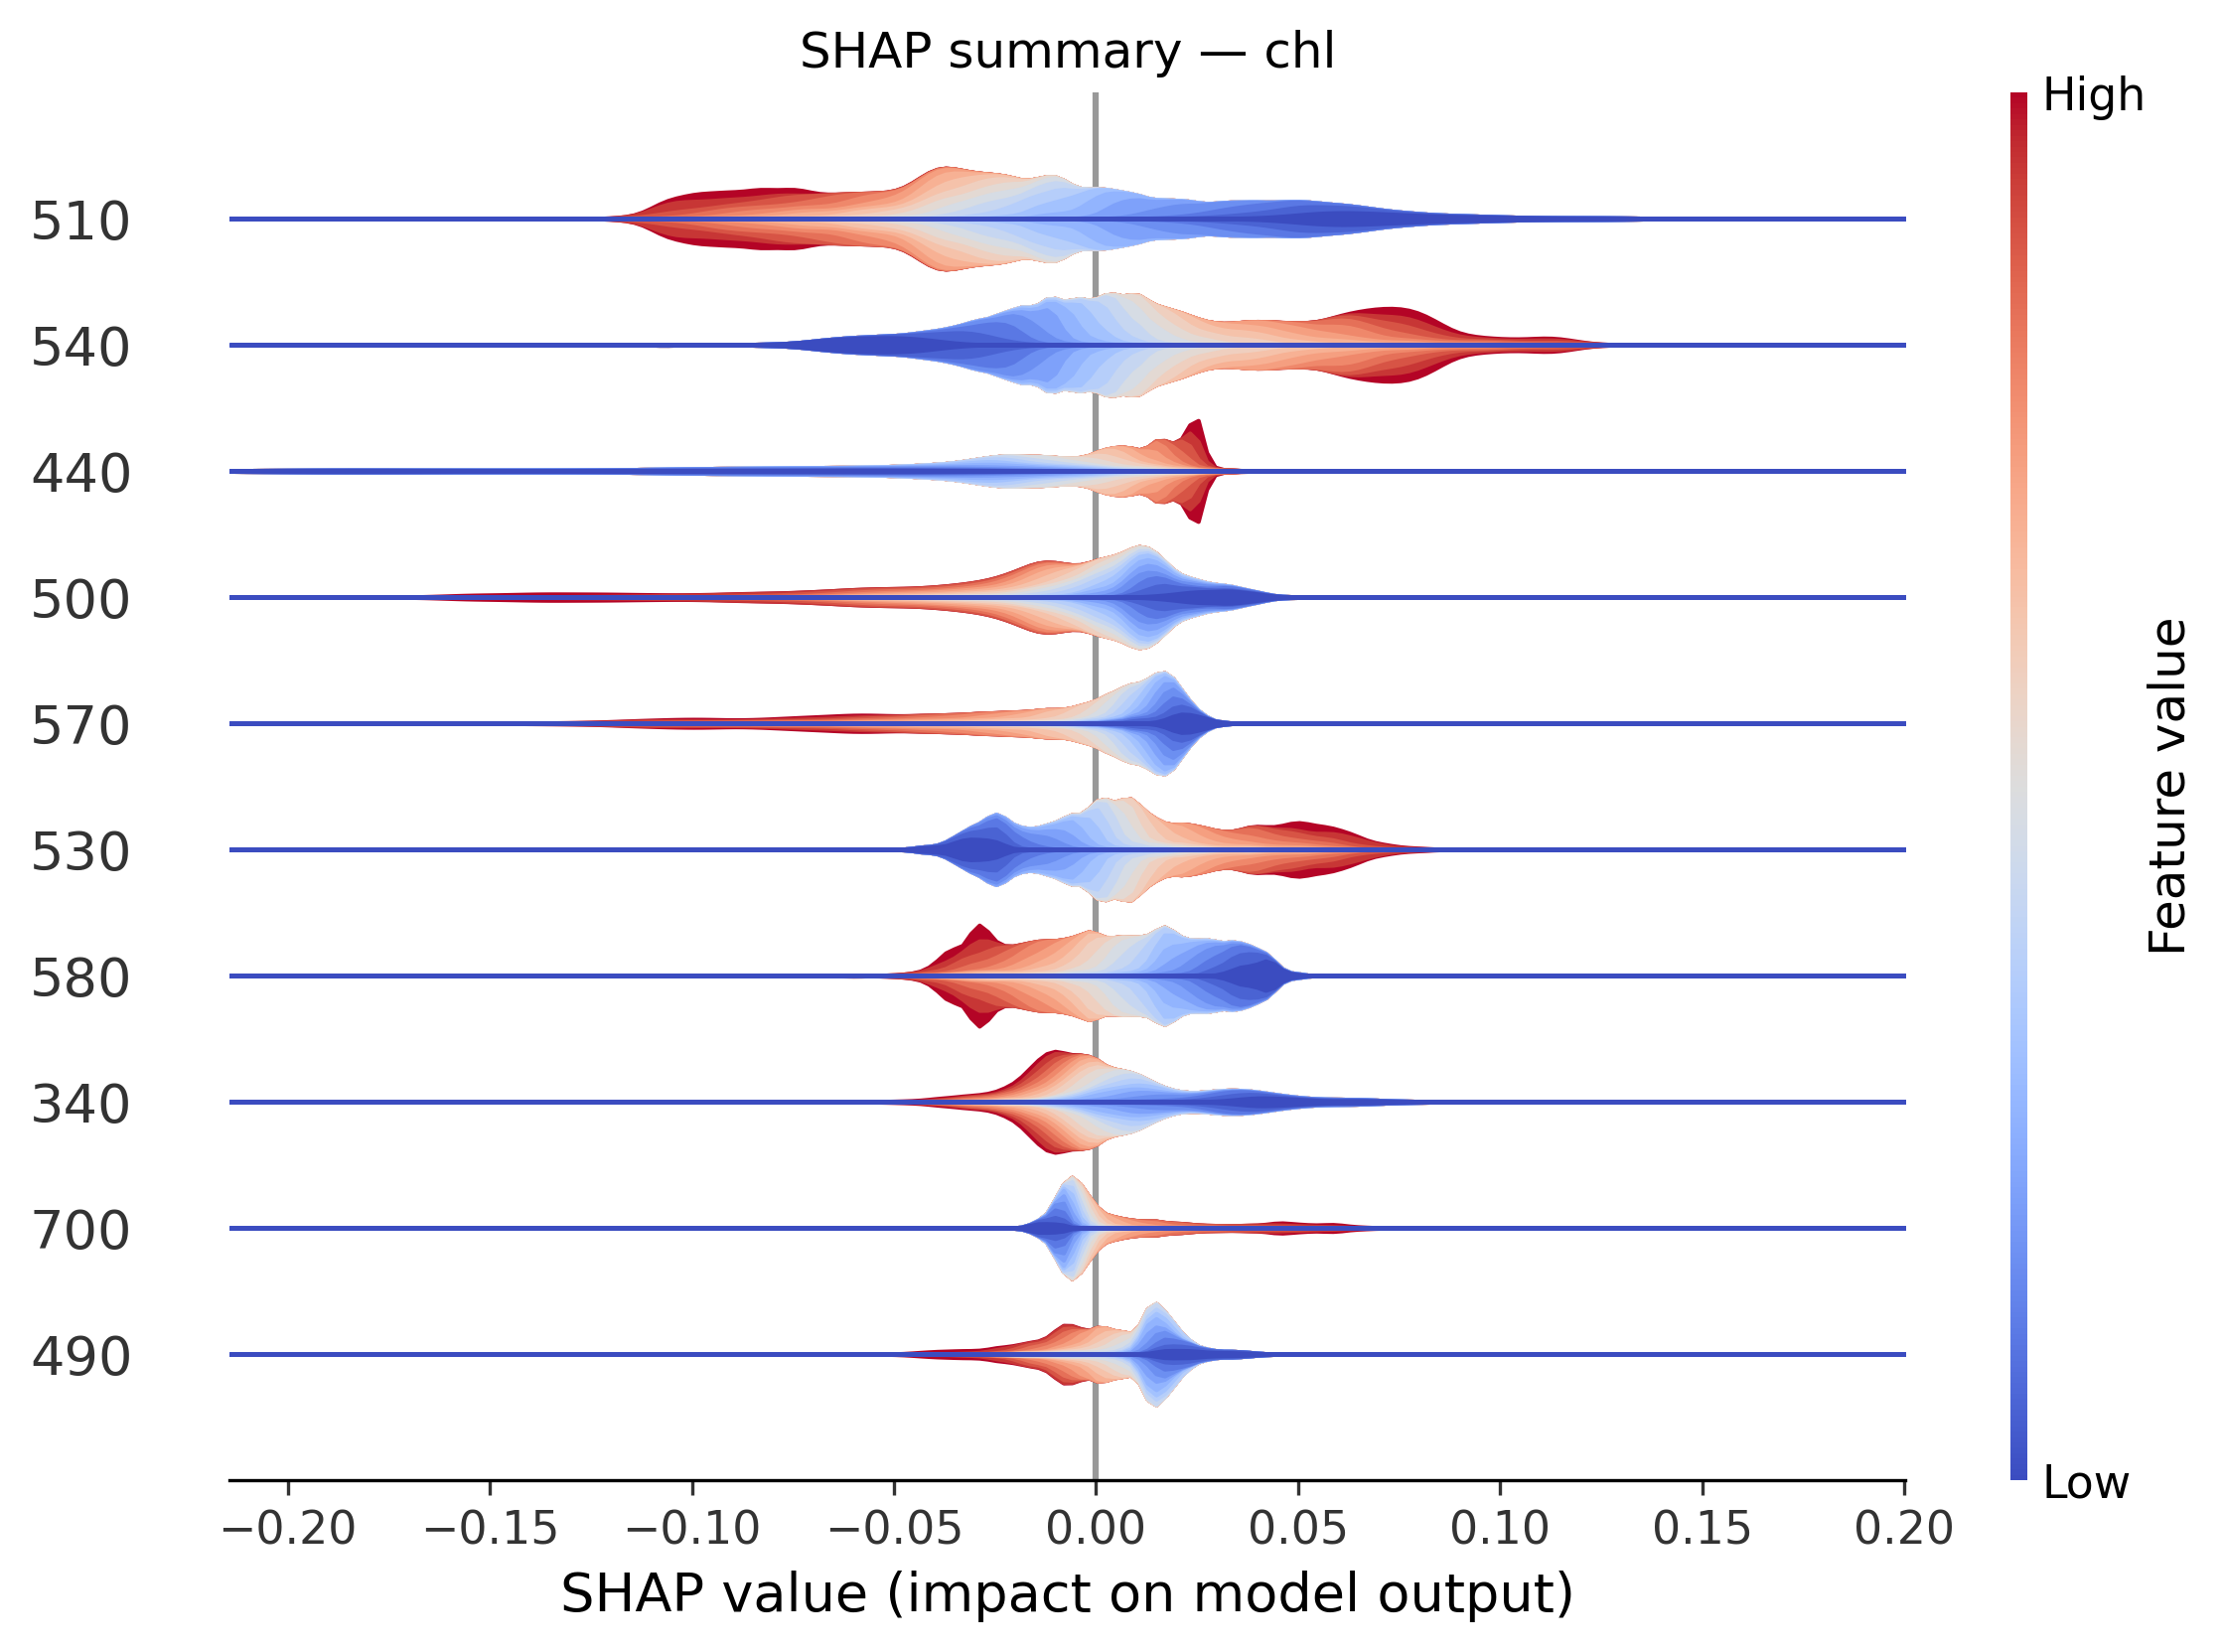

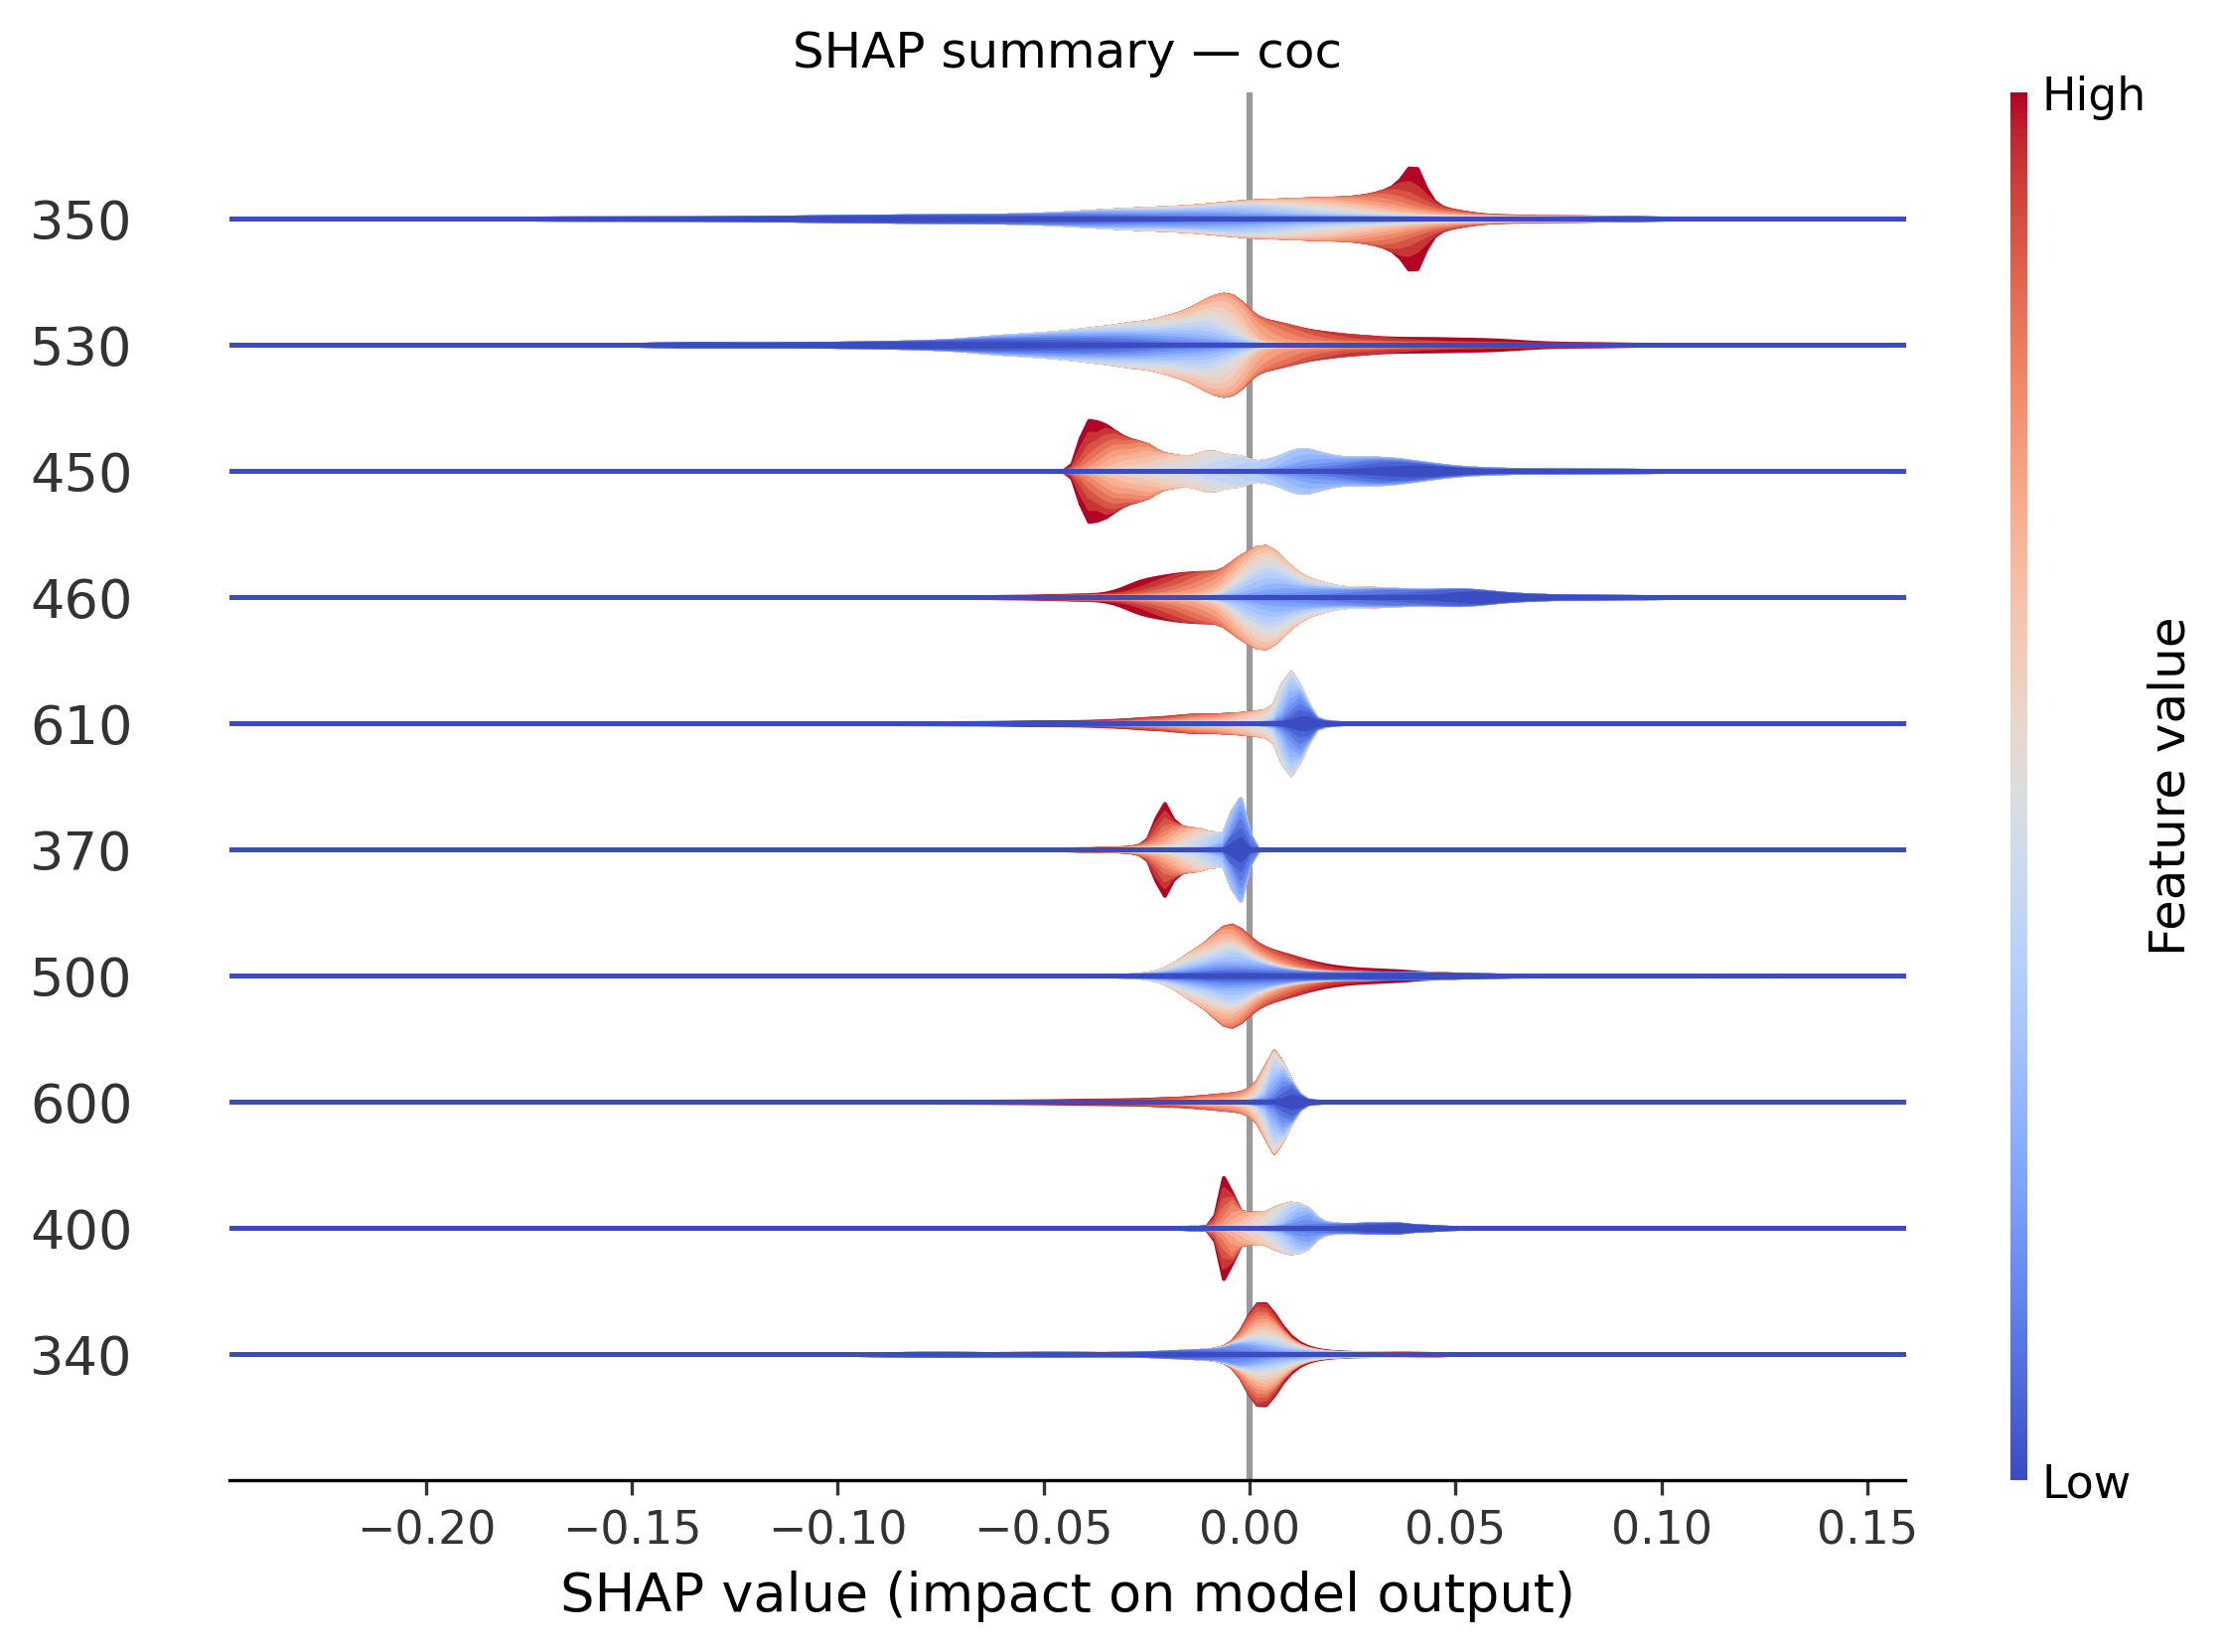

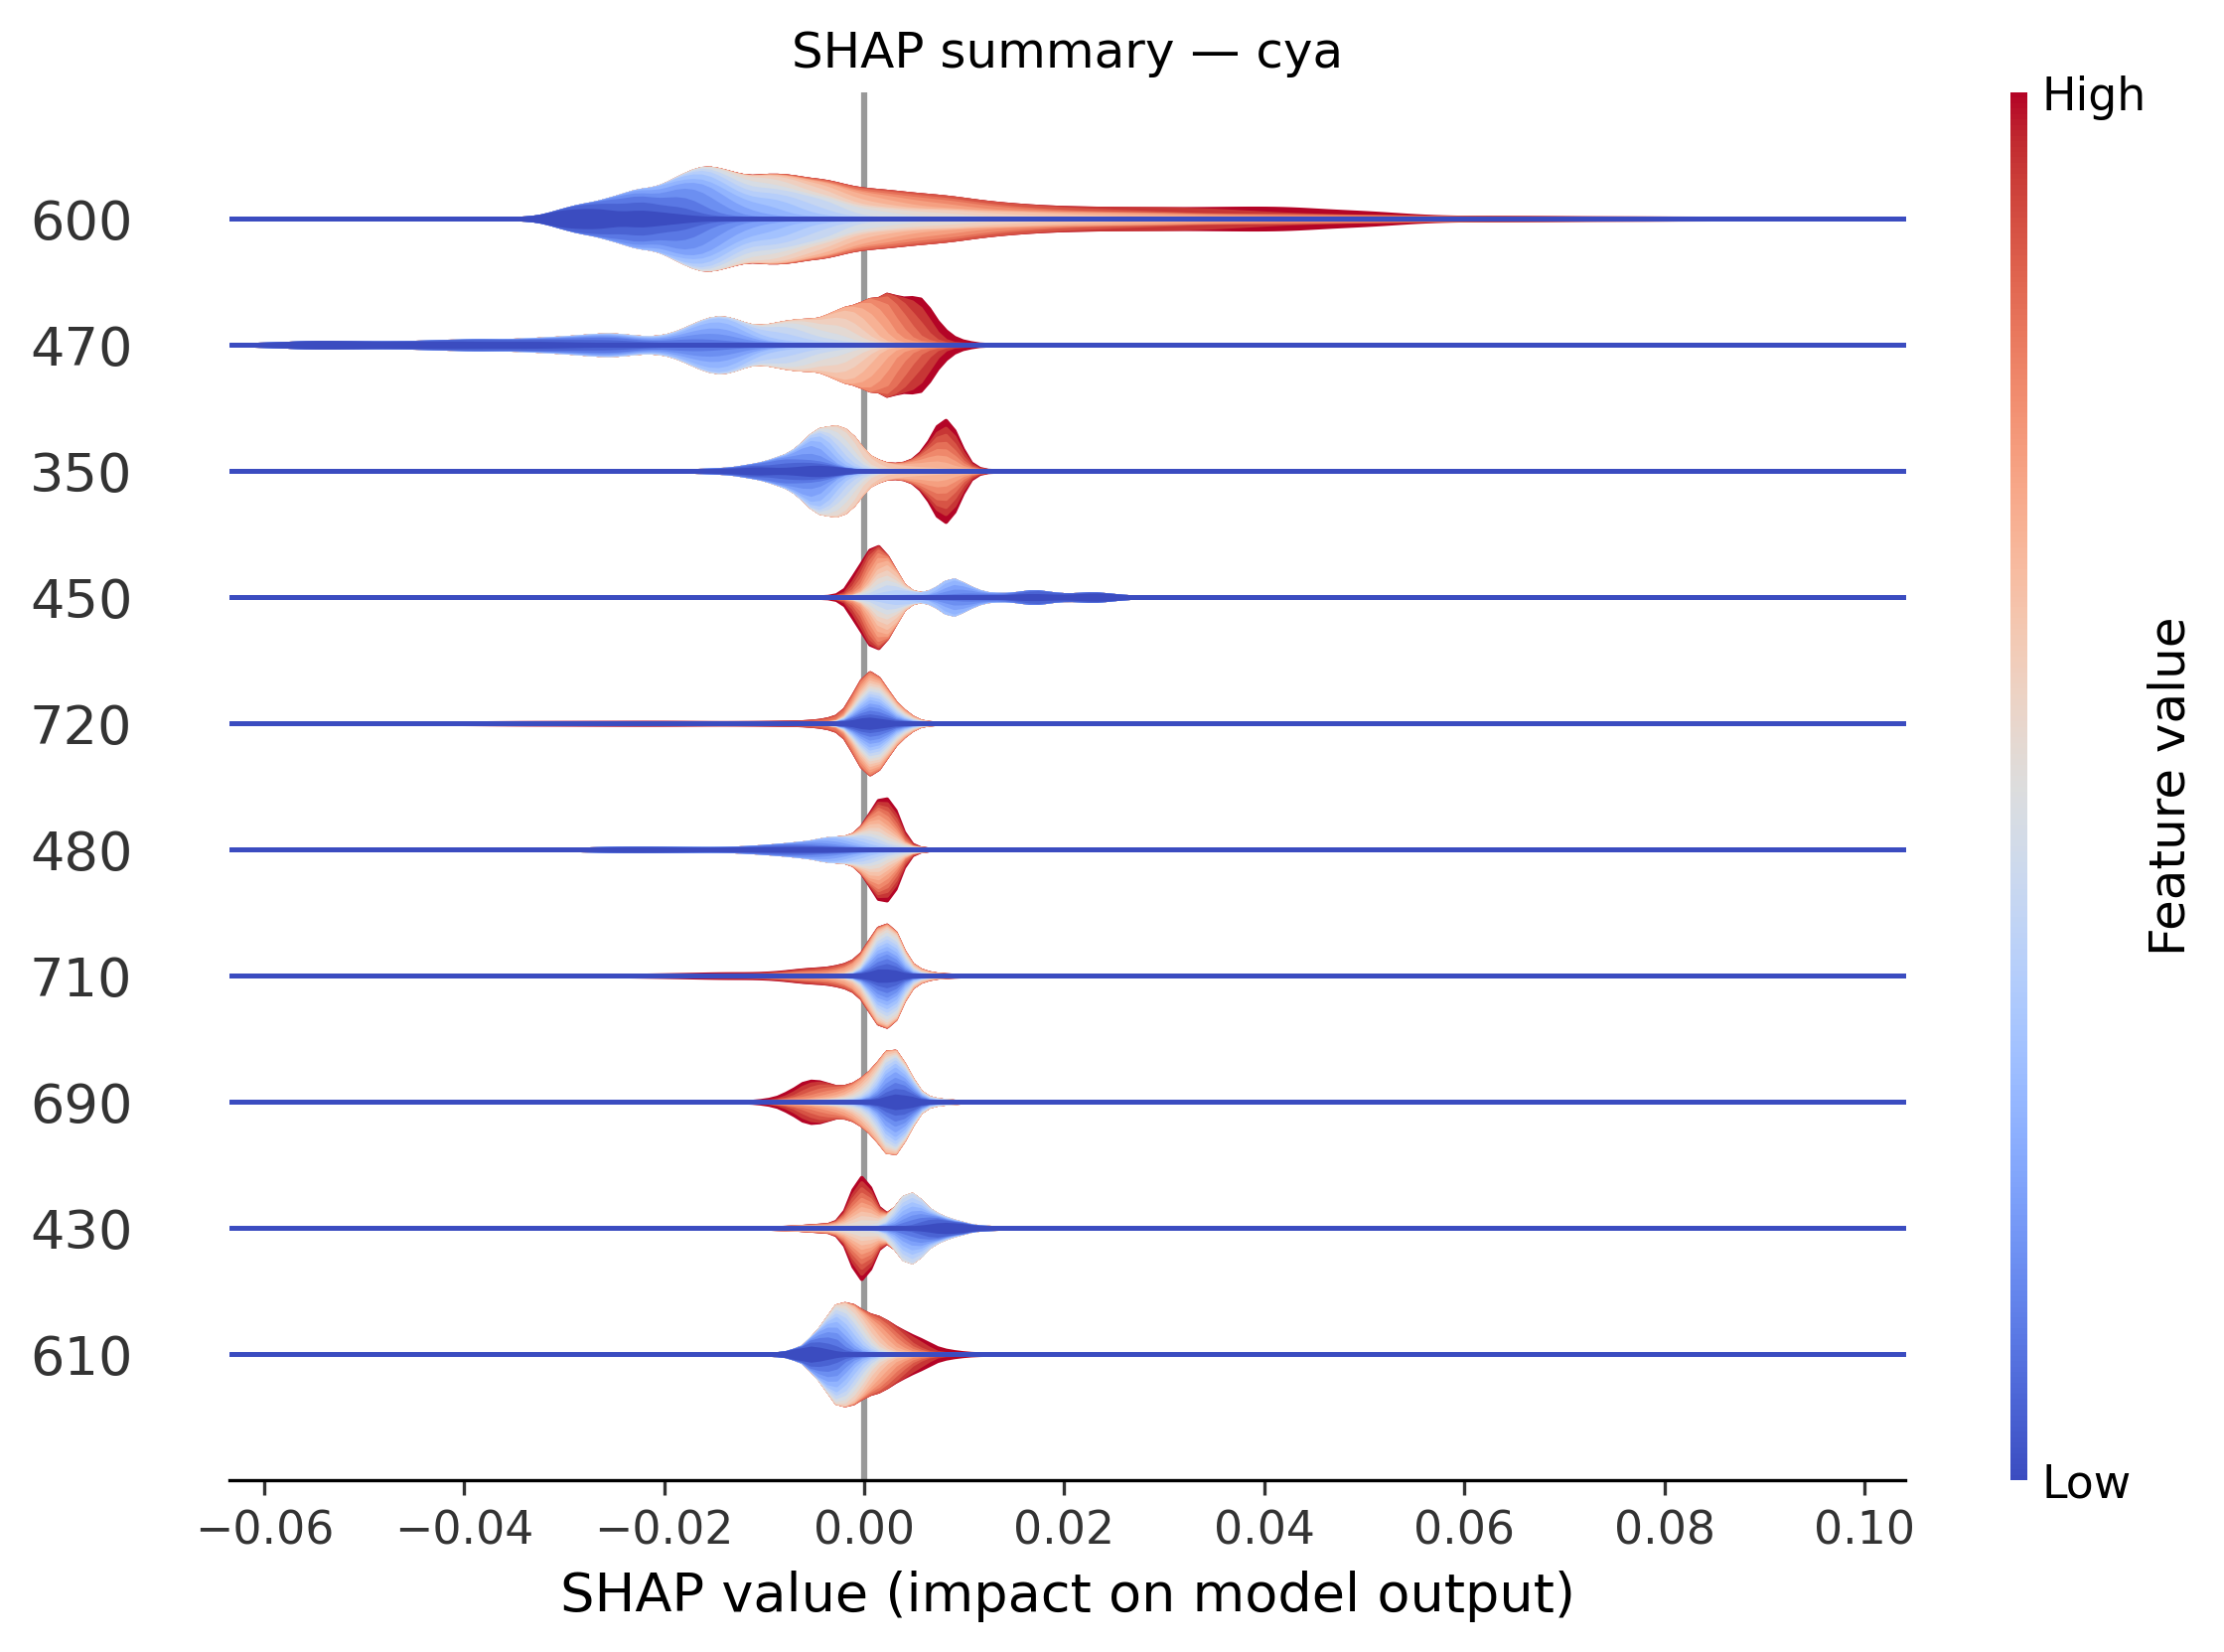

In [35]:
from IPython.display import Image, display
from glob import glob
import pandas as pd

plots = sorted(glob(str(OUTDIR / "shap_*_*.png")))
for p in plots[:3]:
    display(Image(filename=p))

overall_csv = OUTDIR / "shap_feature_ranking_overall.csv"
if overall_csv.exists():
    pd.read_csv(overall_csv).head(10)


## 8) (Optional) Train a final “production” model on **all data**

This refits using the tuned hyperparameters on `(train + test)`. It **does not** overwrite the evaluated model; it saves `model_production.pkl`. DO NOT report metrics for this model (test was used for training) unless new data becomes available.

In [ ]:
FIT_ALL = True  # set False to skip

if FIT_ALL:
    trainer.fit_full(X_df, Y_df)
    PROD_MODEL = OUTDIR / "model_production.pkl"
    trainer.save(PROD_MODEL)
    logger.info("Saved production model trained on ALL data → {}\n", PROD_MODEL)
else:
    logger.info("Skipped production fit (FIT_ALL=False)\n")